# Задача

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

# Описание датасета

1. school — аббревиатура школы, в которой учится ученик
2. sex — пол ученика ('F' - женский, 'M' - мужской)
3. age — возраст ученика (от 15 до 22)
4. address — тип адреса ученика ('U' - городской, 'R' - за городом)
5. famsize — размер семьи('LE3' <= 3, 'GT3' >3)
6. Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
7. Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
8. Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
9. Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
10. Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
11. reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
12. guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
13. traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
14. studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
15. failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
16. schoolsup — дополнительная образовательная поддержка (yes или no)
17. famsup — семейная образовательная поддержка (yes или no)
18. paid — дополнительные платные занятия по математике (yes или no)
19. activities — дополнительные внеучебные занятия (yes или no)
20. nursery — посещал детский сад (yes или no)
21. higher — хочет получить высшее образование (yes или no)
22. internet — наличие интернета дома (yes или no)
23. romantic — в романтических отношениях (yes или no)
24. famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
25. freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
26. goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
27. health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
28. absences — количество пропущенных занятий
29. score — баллы по госэкзамену по математике

# Импорт библиотек

In [856]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

# Предобработка

In [857]:
def find_cat(df, uniq=6,percent=30):
    '''
    Найти все категориальные признаки
    unique - максимальное количество уникальных значений для определения категориальных данных
    "percent" - допустимый процент пропущенных данных в колонке
    '''
    i = 0
    all_rows = len(df)
    for col in df.columns:
        s = ''
        s += col
        u = df[col].nunique()
        empty_rows = np.count_nonzero(df[col].isnull())
        p = round(empty_rows/all_rows*100,2)

        if (type(df[col][0]) == str):
            s += ', строка'
        
        if (u <= uniq):
            l = pd.unique(df[col].values.ravel())
            s += ', мало уникальных (' + str(u) +')' + str(l)

        if (s != col):
            if p == 0:
                t = 'нет пропусков'
            elif p < percent:
                t = 'заполнить пропуски'
            else: 
                t = 'исключить'
            i += 1
            print(f'{i} {p}% {t}, {s}')


def filna_cat_int(df, uniq=6, method='moda'):
    '''
    Заменить пропуски в категориальных данных, выраженных числом указанным методом
    method = 'median' - медиана
    method = 'mean' - среднее
    method = 'moda' - самое частое значение
    method = 'pr' - вероятностное распределение
    '''
    for col in df.columns:
        out = len(df[col]) - df[col].count()# количество пустых строк в колонке
        if out > 0:
            u = df[col].nunique()
            # признак номинативных данных 
            if (type(df[col][0]) == str) or (u <= uniq):
                # выражено не строкой
                if df[col].dtypes != object:
                    if method == 'median':
                        df[col].fillna(df[col].median(),inplace=True)
                    elif method == 'mean':
                        df[col].fillna(df[col].mean(),inplace=True)
                    elif method == 'moda':# самое частое значение
                        df[col].fillna(df[col].value_counts(ascending=False).index[0], inplace=True)
                    elif method == 'pr':
                        # маска Series с булевыми значениями - есть или нет пропуски
                        mask = df[col].isna()
                        # статистика распределения значений
                        p = df[col].value_counts() / len(df[col].dropna())
                        # заполняем пропуски с вероятностью `p`
                        df.loc[mask, col] = np.random.choice(p.index.to_list(),
                                                            size=mask.sum(), 
                                                            p=p.to_list())


def filna_cat_str(df, uniq=6, method='moda'):
    '''
    Заменить пропуски в категориальных данных, выраженных строкой указанным методом
    method = 'moda' - самое частое значение
    method = 'pr' - вероятностное распределение
    '''
    for col in df.columns:
        out = len(df[col]) - df[col].count()# количество пустых строк в колонке
        if out > 0:
            u = df[col].nunique()
            # признак номинативных данных 
            if (type(df[col][0]) == str) or (u <= uniq):
                # выражено строкой
                if df[col].dtypes == object:
                    if method == 'moda':# самое частое значение
                        df[col].fillna(df[col].value_counts(ascending=False).index[0], inplace=True)
                    elif method == 'pr':
                        # маска Series с булевыми значениями - есть или нет пропуски
                        mask = df[col].isna()
                        # статистика распределения значений
                        p = df[col].value_counts() / len(df[col].dropna())
                        # заполняем пропуски с вероятностью `p`
                        df.loc[mask, col] = np.random.choice(p.index.to_list(),
                                                            size=mask.sum(), 
                                                            p=p.to_list())


def get_boxpot(df, list_column, orientation="h"):
    '''
    Рисует ящик с усами
    list_column - список колонок
    orientation="h" - горизонтальная ориентация
    orientation="v" - вертикальная ориентация
    '''
    g = sns.boxplot(data=df[list_column],
                orient=orientation, palette="Set2", whis=1.5);



def interquartile_range(series):
    '''
    Вычисляет межквартильный размах в серии
    '''
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    print('25-й перцентиль: {},'.format(perc25),
          '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR), 
          "Границы выбросов: [{}, {}].".format(f,l))
    
    series.loc[series.between(perc25 - 1.5*IQR,
                              perc75 + 1.5*IQR)].hist(bins = 8, 
                                                      range = (0, 30), 
                                                      label = 'IQR')
    plt.legend();


def emission_replacement(df,column,method='median'):
    '''
    Заменяет выбросы в серии вычисленным значением 
    method='median' - замена на медиану
    method='average' - замена на среднее
    method ='probable' - вероятностное распределение
    '''
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if method =='median':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].median()
    elif method =='average':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].mean()
    elif method =='probable':
        # замена выбросов на nan 
        df[column] = np.where((df[column] < f) | (df[column] > l), np.nan, df[column])
        # маска Series с булевыми значениями - есть или нет пропуски
        mask = df[column].isna()
        # статистика распределения значений
        p = df[column].value_counts() / len(df[column].dropna())
        # заполняем пропуски с вероятностью `p`
        df.loc[mask, column] = np.random.choice(p.index.to_list(),
                                            size=mask.sum(), 
                                            p=p.to_list())


def emissions_del(df,column):
    '''
    Удалить выбросы
    '''
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    df = df.loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return df

def make_conj(df, cat1, cat2):
    '''
    Конъюнкция 2-х категориальных признаков
    '''
    df[cat1 + '+' + cat2] = df[cat1].astype(str) + '+' + df[cat2].astype(str)

    return df


def get_list_object(df):
    '''
    Возвращает список столбцов со строковыми значениями
    '''
    l = []
    for col in df.columns:
        if df[col].dtypes == object:
            l.append(col)
    return l

def get_boolean(df,list_column):
    '''
    Заменяет по списку колонок строковые значения yes и no на 1 и 0
    '''
    for col in df.columns:
        if col in list_column:
            if df[col].dtypes == object:
                df[col] = np.where(df[col] == 'yes', 1, 0)


def get_boxplot(df,column,ax_y='score'):
    '''
    График плотности распределения переменных для количественного признака
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(df,column,target='score'):
    '''
    тест Стьюдента
    '''
    # cols = df.loc[:, column].value_counts().index[:10]
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target], 
                        df.loc[df.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Первичный отсмотр данных

In [858]:
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Переименуем один из столбцов для удобства

In [859]:
stud = stud.rename({
    'studytime, granular': 'studytime_granular'}, axis=1)

В датасете содержатся данные различных типов:
1. Количественные переменные
2. Качественные (номинативные) переменные, выраженные цифрами и строками

Можно также отдельно выделить ранговые переменные, но так как сейчас нет необходимости их сравнения, отнесём их к числу номинативных. 


## Категориальные (номинативные) признаки


Определим какие колонки относятся к категориальным(номинативным) данным. Это можно сделать как минимум по 2-м признакам:
* строковые значения в столбцах
* слишком мало уникальных значений

Воспользуемся функцией `find_cat` (вынесена в предобработку)

Установим 7 как минимальное количество уникальных значений для определения номинативного признака (при 8 - в отбор попадает age - возраст, а это уже количественный непрерывный признак, выраженный дискретно)

In [860]:
find_cat(stud, uniq=7, percent=30)

1 0.0% нет пропусков, school, строка, мало уникальных (2)['GP' 'MS']
2 0.0% нет пропусков, sex, строка, мало уникальных (2)['F' 'M']
3 4.3% заполнить пропуски, address, строка, мало уникальных (2)['U' nan 'R']
4 6.84% заполнить пропуски, famsize, мало уникальных (2)[nan 'GT3' 'LE3']
5 11.39% заполнить пропуски, Pstatus, строка, мало уникальных (2)['A' nan 'T']
6 0.76% заполнить пропуски, Medu, мало уникальных (5)[ 4.  1.  3.  2. nan  0.]
7 6.08% заполнить пропуски, Fedu, мало уникальных (6)[ 4.  1.  2.  3. 40. nan  0.]
8 4.81% заполнить пропуски, Mjob, строка, мало уникальных (5)['at_home' 'health' 'other' 'services' 'teacher' nan]
9 9.11% заполнить пропуски, Fjob, строка, мало уникальных (5)['teacher' 'other' nan 'health' 'services' 'at_home']
10 4.3% заполнить пропуски, reason, строка, мало уникальных (4)['course' 'other' 'home' 'reputation' nan]
11 7.85% заполнить пропуски, guardian, строка, мало уникальных (3)['mother' 'father' 'other' nan]
12 7.09% заполнить пропуски, traveltime, 

* Получили 27 из 30 колонок, содержащие номинативные переменные.
* % пропущенных данных. Если исходить из того, что восстанавливать данные имеет смысл, если пропущенно менее 30%, то во всех колонках с номинативными данными, возможно заполнение пропусков.
* Для каждой колонки - количество уникальных значений и список таких значений.
* В соответствии с описанием датафрейма - большинство колонок имеют действительные интервалы значений.

Исключение:
* "Fedu" - есть значение "40" - не входит в действительный интервал
* "famrel" - есть значение "-1" - тоже за пределами действительных значений
* "studytime_granular" - нет описания в задании. Нужен дополнительный анализ

### famrel и Fedu

* В колонке "famrel" - минимальное значение -1, хотя по описанию - значения должны быть в интервале от 1 до 5.
* "Fedu" - максимальное значение 40, должен быть интервал от 0 до 4

In [861]:
print(f'Fedu {stud.Fedu[stud.Fedu == stud.Fedu.max()].count()}')
print(f'famrel {stud.famrel[stud.famrel == stud.famrel.min()].count()}')

Fedu 1
famrel 1


В каждой из этих колонок по 1-й строке с таким ошибочным значением. По здравому смыслу можно исправить их на ближайшее верное значение(40 = 4, -1 = 1). Тогда все значения будут находиться в действительном диапазоне.

In [862]:
stud.loc[stud.Fedu == 40,'Fedu'] = 4
stud.loc[stud.famrel == -1,'famrel'] = 1

### studytime_granular	

Нет описания этого столбца в задании => не ясно какие значения действительные. Возможно есть какая-то связь с данными из "studytime" (обращает на себя внимание сходство названий).
Для проверки этой гипотезы проведём корреляционный анализ:

In [863]:
correlation = stud[['studytime','studytime_granular']].corr()
correlation

,studytime,studytime_granular
studytime,1.0,-1.0
studytime_granular,-1.0,1.0


* Анализ показывает обратную зависимость значений studytime_granular от studytime
* Возможно есть и другие зависимости. Пока оставим этот параметр под наблюдением. Окончательное решение примем после проведения общего корреляционного анализа

## Замена пропусков

В оставшихся колонках с номинативными переменными необходимо произвести замену nan на какое-либо значение.
Можно провести замену на:
* Моду
* Медиану
* Среднее
* Вероятностное распределение


In [864]:
# Замена пропусков среди числовых данных
# method=  moda, median, mean, pr
filna_cat_int(stud,uniq=7,method='median')

# Замена пропусков среди строковых данных
# method=  moda, pr
filna_cat_str(stud,uniq=7,method='moda')

find_cat(stud)

1 0.0% нет пропусков, school, строка, мало уникальных (2)['GP' 'MS']
2 0.0% нет пропусков, sex, строка, мало уникальных (2)['F' 'M']
3 0.0% нет пропусков, address, строка, мало уникальных (2)['U' 'R']
4 0.0% нет пропусков, famsize, строка, мало уникальных (2)['GT3' 'LE3']
5 0.0% нет пропусков, Pstatus, строка, мало уникальных (2)['A' 'T']
6 0.0% нет пропусков, Medu, мало уникальных (5)[4. 1. 3. 2. 0.]
7 0.0% нет пропусков, Fedu, мало уникальных (5)[4. 1. 2. 3. 0.]
8 0.0% нет пропусков, Mjob, строка, мало уникальных (5)['at_home' 'health' 'other' 'services' 'teacher']
9 0.0% нет пропусков, Fjob, строка, мало уникальных (5)['teacher' 'other' 'health' 'services' 'at_home']
10 0.0% нет пропусков, reason, строка, мало уникальных (4)['course' 'other' 'home' 'reputation']
11 0.0% нет пропусков, guardian, строка, мало уникальных (3)['mother' 'father' 'other']
12 0.0% нет пропусков, traveltime, мало уникальных (4)[2. 1. 3. 4.]
13 0.0% нет пропусков, studytime, мало уникальных (4)[2. 3. 1. 4.]
1

## Выводы по номинативным признакам:


* Устранены пропуски
* Исправлены ошибочные данные
* Все признаки находятся в достоверных интервалах

## Количественные признаки



Остались 3 количественных признака
* age
* absences
* score

Оценим все числовые переменные датафрейма. Определим - есть ли выбросы.

In [865]:
l = ['age', 'absences','score']
stud[l].describe()

,age,absences,score
count,395.000000,383.000000,389.000000
mean,16.696203,7.279373,52.262211
std,1.276043,23.465197,22.919022
min,15.000000,0.000000,0.000000
25%,16.000000,0.000000,40.000000
50%,17.000000,4.000000,55.000000
75%,18.000000,8.000000,70.000000
max,22.000000,385.000000,100.000000


### score
баллы по госэкзамену по математике

Это самая важная колонка - целевая функция. Именно это значение должна будет предсказывать модель. Пропусков данных в ней не должно быть.

Посмотрим на распределение

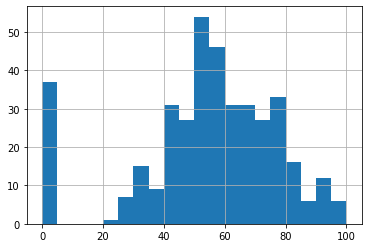

In [866]:
stud.score.hist(bins=20);

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


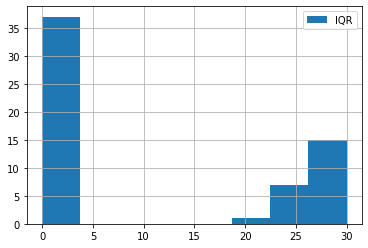

In [867]:
# Выбросы
interquartile_range(stud.score)

Обращаем внимание:
* более 30 учеников, получивших 0 баллов
* 'яма' в диапазоне от 0 до 20 после чего начинается нормальное распределение
* выбросов нет

Посмотрим на баллы, как на группы

In [868]:
stud.score.value_counts().sort_index(ascending=False)

100.0     1
95.0      5
90.0     12
85.0      6
80.0     16
75.0     33
70.0     27
65.0     31
60.0     31
55.0     46
50.0     54
45.0     27
40.0     31
35.0      9
30.0     15
25.0      7
20.0      1
0.0      37
Name: score, dtype: int64

* Все баллы кратны 5 => скорее всего это минимальный балл за задание
* Возможно "20" - минимальный проходной балл, а все кто набрал < 20 получили "0"
* Так же возможно, что 0 получили в результате аннулирования оценки (например, за списывание)
* Не исключено, что 0 получили не явившиеся на экамен
* Возможно 0 - это ошибки в датасете
* Возможно и сочетание этих факторов

В столбце также присутствуют пропущенные данные. Можно предположить, что прпуск = 0. Тогда можно пойти 2-мя путями:
1. Заменить nan на 0
2. Удалить строки с nan

#### ВАРИАНТ 1 - замена пропусков на 0

In [869]:
stud.score.fillna(0,inplace=True)

#### ВАРИАНТ 2 - удаление пропусков

In [870]:
# stud.dropna(subset=['score'],inplace=True)
# stud = stud.reset_index(drop=True)# сбросим индексы

### age
возраст - от 15 ло 22 лет

count    395.000000
mean       0.318987
std        0.726244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

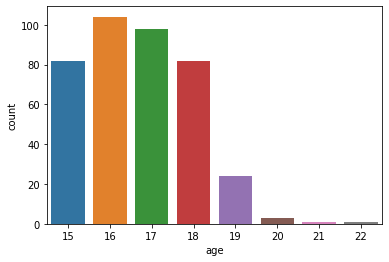

In [871]:
sns.countplot(x = 'age', data = stud)
stud.failures.describe()

* все данные находятся в действительных рамках
* пропусков нет

### absences
Количество пропущенных занятий

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

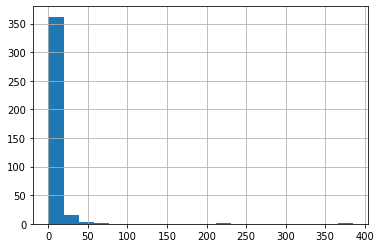

In [872]:
stud.absences.hist(bins=20);
stud.absences.describe()

Судя по распределению можно сделать выводы:
* Есть пропуски
* Основная часть значений (пропущенных занятий) лежит в диапазоне от 0 до примерно 20
* Есть выбросы






#### Замена пропусков

Заменим на медиану

In [873]:
stud.absences.fillna(stud.absences.median(),inplace=True)

Оценим выбросы (функция в предобработке)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


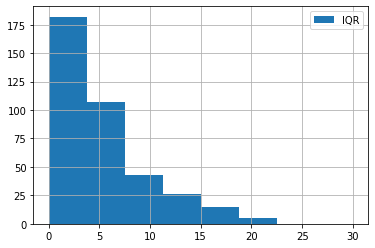

In [874]:
interquartile_range(stud.absences)

Действительно, значения > 20 попадают за границу выбросов. Но есть 2 значения, которые очень значительно отличаются от остальных - более 200 пропущенных занятий. Возможно это ошибка в сборе данных? В таком случае интересно будет посмотреть на итоговые оценки учеников с таким большим количеством пропущенных занятий.
Посмотрим на итоговый бал 10 учеников с самым большим числом пропущенных занятий:

In [875]:
stud[['absences','score']].sort_values('absences', ascending=False).head(10)

,absences,score
222,385.0,85.0
390,212.0,45.0
276,75.0,45.0
183,56.0,40.0
74,54.0,55.0
315,40.0,55.0
307,38.0,40.0
280,30.0,40.0
205,28.0,45.0
103,26.0,30.0


Оказывается, что ученик с самым большим число пропущенных занятий входит в 20-ку лучших по итоговому баллу (строка с индексом 221).

In [876]:
stud[['absences','score']].sort_values('score', ascending=False).head(20)

,absences,score
47,4.0,100.0
113,10.0,95.0
286,5.0,95.0
110,6.0,95.0
8,0.0,95.0
374,0.0,95.0
129,4.0,90.0
198,24.0,90.0
36,2.0,90.0
260,21.0,90.0


выбросы

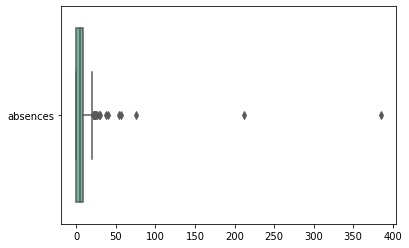

In [877]:
get_boxpot(stud,['absences'])

#### Замена выбросов

##### ВАРИАНТ 1

Нельзя однозначно сказать попадают ли значчения 385 и 212 в число действительных (возможно ученики болели и учились дистанционно и т.д.). Нам не известно и сколько всего было занятий. Но эти числа явно будут существенно влиять на модель.
Заменим на медиану только 2 этих значения.

In [878]:
stud['absences'] = np.where((stud['absences'] == 385) | 
                          (stud['absences'] == 212), stud['absences'].median(), stud['absences'])

##### ВАРИАНТ 2

Заменим все выбросы, на медиану.
Воспользуемся функцией `emission_replacement` (в предобработке)

In [879]:
emission_replacement(stud,'absences',method='median')

In [880]:
stud[l].describe()

,age,absences,score
count,395.000000,395.000000,395.000000
mean,16.696203,4.559494,51.468354
std,1.276043,4.781880,23.627199
min,15.000000,0.000000,0.000000
25%,16.000000,0.000000,40.000000
50%,17.000000,4.000000,55.000000
75%,18.000000,6.000000,70.000000
max,22.000000,20.000000,100.000000


Теперь данные выглядят лучше.


### Вывод по количественным данным:

1. Необходимо по возможности получить информацию о процедуре оценки (колонка score) - почему нет данных, за что 0, почему такое значительное число 0 среди оценок (возможно это аномалия). Пока поставить под наблюдение группу оценок "0". На этом этапе - пропуски устранены (заменены на 0)
2. В остальных количественных данных - пропуски заменены на медиану, единичные выбросы заменены на ближайшее из действительного диапазона, выбросы в absences заменены на медиану

## Корреляционный анализ

Выясним, какие столбцы коррелируют с итоговой оценкой. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

Корреляции рассмотрим только для числовых столбцов.

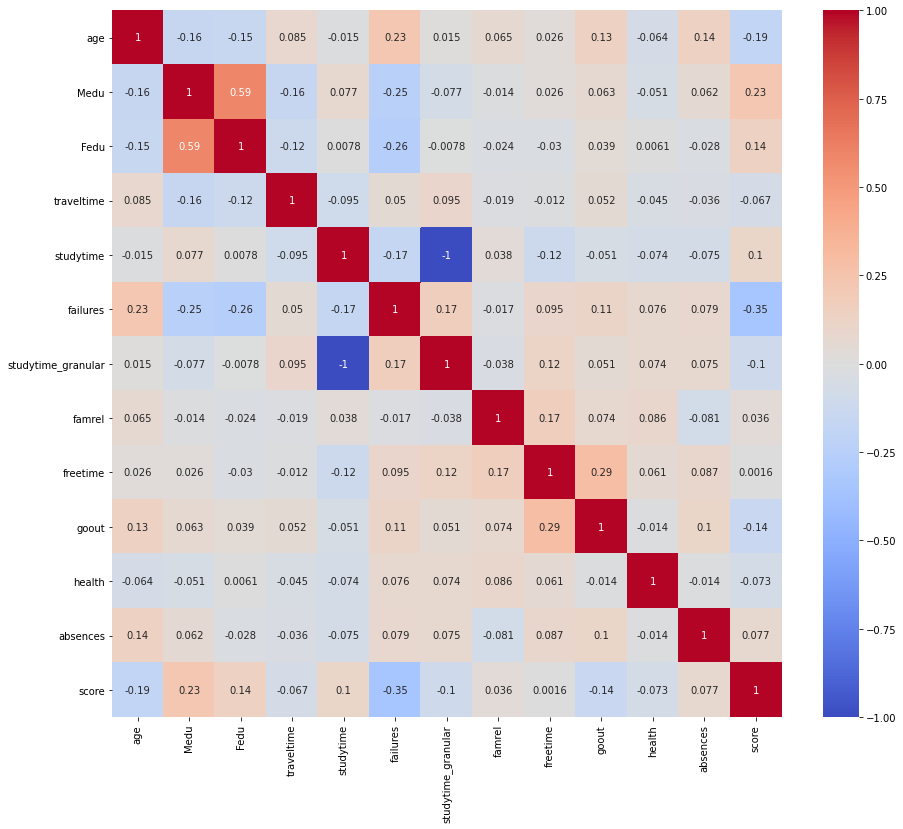

In [882]:
correlation = stud.corr() #  матрица корреляций
plt.figure(figsize=(15, 13))# размер тепловой карты
sns.heatmap(correlation, annot=True, cmap='coolwarm');

Как мы отметили ранее 'studytime_granular' - имееет обратную корреляцию с 'studytime'. От этого столбца можно отказаться.

In [883]:
stud.drop('studytime_granular', axis=1, inplace=True)

### ВАРИАНТ - создание дополнительных параметров

В описании датасета есть ряд колонок, которые можно условно обЪединить:

Дополнительные занятия
* schoolsup — дополнительная образовательная поддержка (yes или no)
* famsup — семейная образовательная поддержка (yes или no)
* paid — дополнительные платные занятия по математике (yes или no)
* activities — дополнительные внеучебные занятия (yes или no)

Образование родителей
* Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Гипотезы:
1. Дополнительные занятия влияют на итоговый балл
2. Образование родителей влияет на итоговый балл.

Для проверки гипотез нужно создать 2 дополнительных параметра:


#### доп_занятия

In [884]:
# yes и no переведём в цифры и создадим новый количественный признак, просуммировав значения
l = ['schoolsup','famsup','paid','activities']
get_boolean(stud,l)
stud['доп_занятия'] = stud[l].sum(axis=1)

# Удалить источники
stud.drop(l, axis=1, inplace=True)

#### образование_родителей

In [885]:
# Суммируем значения, отражающие образование родителей 
stud['образование_родителей'] = stud[['Medu','Fedu']].sum(axis=1)

# Удалить источники
stud.drop(['Medu','Fedu'], axis=1, inplace=True)

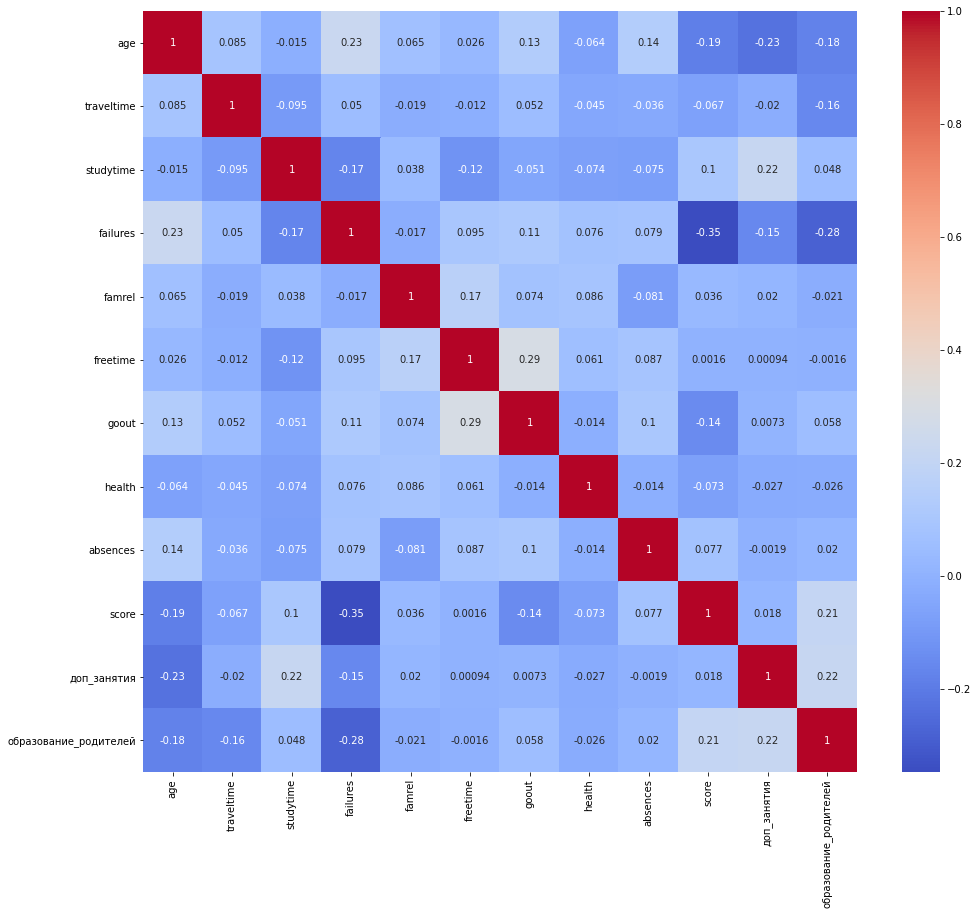

In [886]:
correlation = stud.corr() #  матрица корреляций
plt.figure(figsize=(16, 14))# размер тепловой карты
sns.heatmap(correlation, annot=True, cmap='coolwarm');

Очевидно, что создание новых прзнаков было не напрасно:
* образование_родителей имеет более высокую корреляцию с итоговым баллом и дополнительными занятиями, чем остальные параметры (кроме fileures). И обратную зависимость с failures (количество внеучебных неудач)
* доп_занятия - обратно коррелируют с age, прямо - со studytime (что закономерно), но довольно слабо связано с итоговым баллом (что несколько неожиданно).

Все остальные признаки можно оставить в датафрейме.

In [818]:
# Список нужных параметров
resume_list = ['age','traveltime','studytime','failures','famrel','freetime','goout','health','absences','score','доп_занятия','образование_родителей']

## Анализ номинативных переменных

Будем анализировать номинативные переменные, выраженные в строках, так как для них провести корреляционный анализ невозможно (если только не приеобразовать их в числовые значения).
Для получения списка колонок, содержащих строковые переменные, воспользуемся функцией `get_list_object`

In [819]:
st_list = get_list_object(stud)
st_list

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'nursery',
 'higher',
 'internet',
 'romantic']

Уникальных значений в них не более 5, поэтому не будем ограничивать частотность.

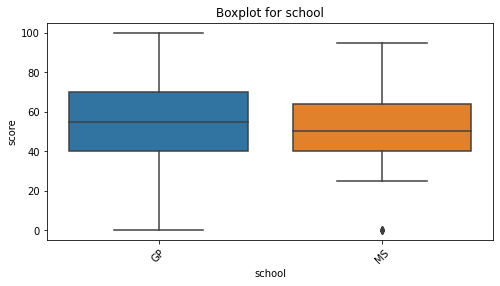

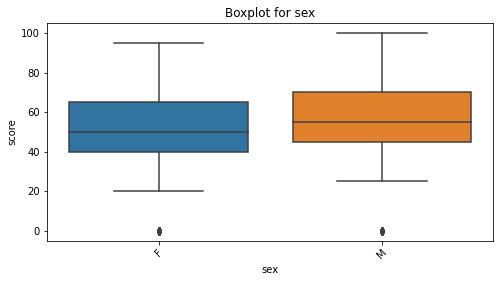

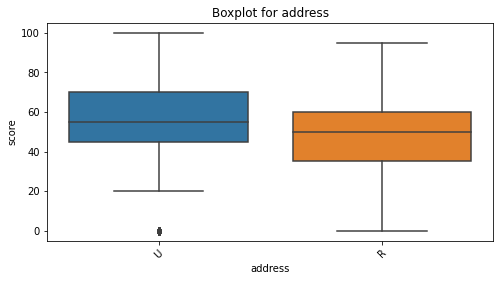

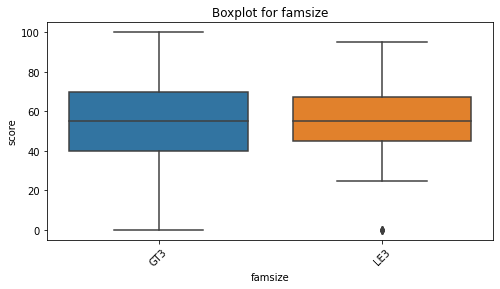

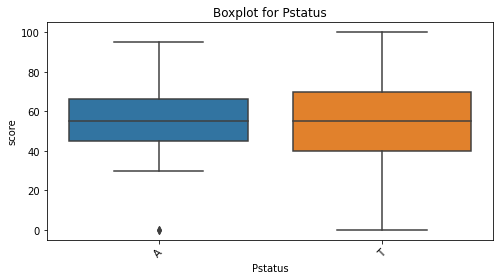

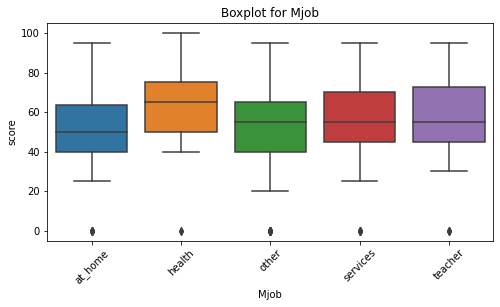

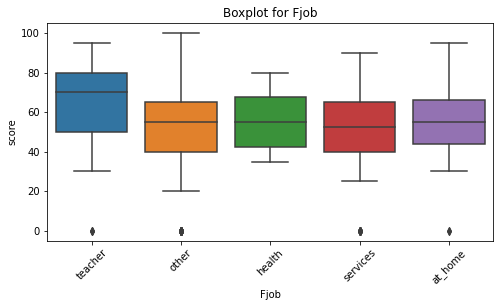

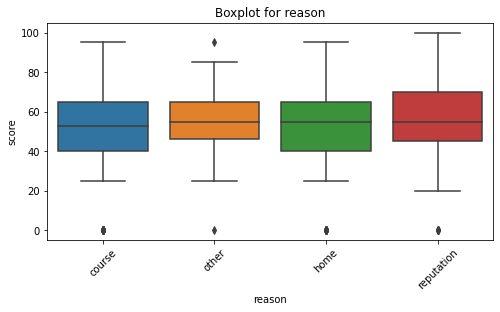

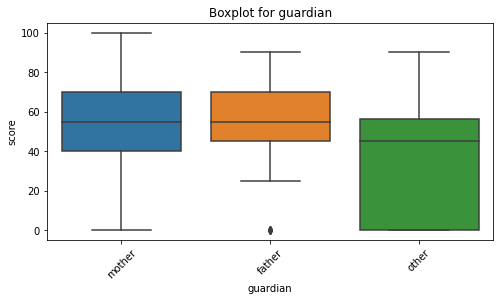

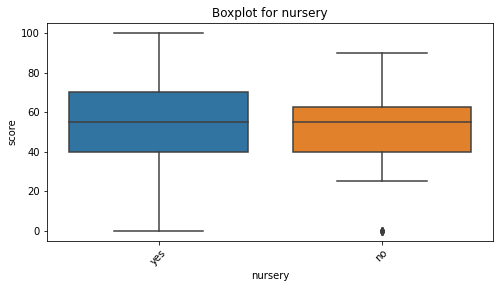

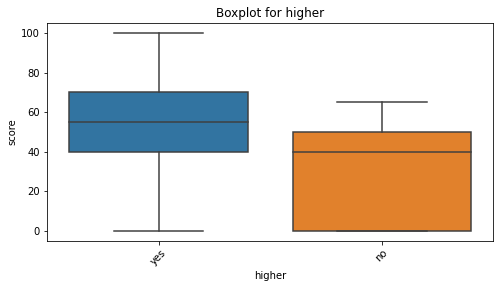

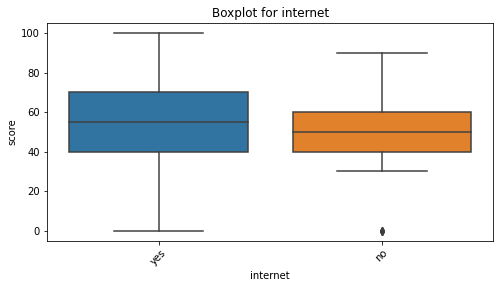

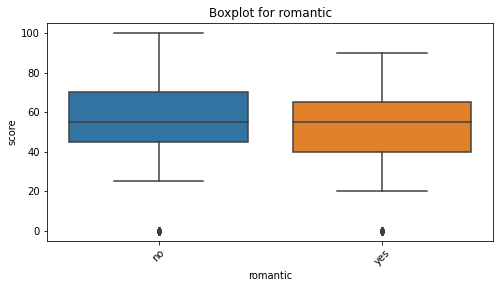

In [820]:
for col in st_list:
    get_boxplot(stud,col)

Проверим, есть ли статистическая разница в распределении баллов по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения итоговых баллов по математике по различным параметрам неразличимы:

In [821]:
for col in st_list:
    get_stat_dif(stud,col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки guardian
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Тест Стьюдента показал, что серьёзно отличаются 6 параметров:

`'sex','address', 'Mjob', 'guardian', 'higher', 'romantic'`

Оставим эти переменные в датасете для дальнейшего построения модели.

Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку, это:

In [822]:
l = ['sex','address', 'Mjob', 'guardian', 'higher', 'romantic']

for i in l:
    resume_list.append(i)
resume_list

['age',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences',
 'score',
 'доп_занятия',
 'образование_родителей',
 'sex',
 'address',
 'Mjob',
 'guardian',
 'higher',
 'romantic']

In [823]:
stud_for_model = stud.loc[:, resume_list]
stud_for_model.head()

,age,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,доп_занятия,образование_родителей,sex,address,Mjob,guardian,higher,romantic
0,18,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0,1,8.0,F,U,at_home,mother,yes,no
1,17,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0,1,2.0,F,U,at_home,father,yes,no
2,15,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0,50.0,1,2.0,F,U,at_home,mother,yes,no
3,15,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,75.0,3,6.0,F,U,health,mother,yes,yes
4,16,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0,2,6.0,F,U,other,father,yes,no


# Выводы

В результате EDA были получены следующие выводы:

* В данных мало пустых значений - не более 11%
* Значительные выбросы найдены только в столбце с данными о пропущенных занятиях. Данные достаточно чистые.
* 'studytime_granular' - имееет обратную корреляцию с 'studytime'. Исключили этот параметр.
* Из 2-х признаков (образование отца и образование матери) был создан новый признак - образование_родителей. Он имеет более высокую корреляцию с итоговым баллом и дополнительными занятиями, чем остальные параметры (кроме fileures). И обратную зависимость с failures (количество внеучебных неудач).
* Несколько параметров, обозначающих степень дополнительных занятий вне школы, был создан новый признак - доп_занятия. Он обратно коррелируют с age, прямо - со studytime (что закономерно), но довольно слабо связан с итоговым баллом (что несколько неожиданно).


Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели:

age, traveltime, studytime, failures, famrel, freetime,	goout, health, absences, score,	доп_занятия, образование_родителей,	sex, address, Mjob, guardian, higher, romantic.